In [28]:
from keras.layers import Conv2D,Input,MaxPooling2D,Conv2DTranspose,Dropout,BatchNormalization,Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import random

In [18]:
img_cols=64
img_rows=64
num_channels=7
num_mask_channels=2

In [2]:
MaxPooling2D??

Object `MaxPooling2D` not found.


In [19]:
def define_model(input_shape,num):
    ipt = Input(shape=input_shape)
    print(ipt.shape)
    x = Conv2D(64,kernel_size=3,padding='same',strides=1,activation='relu')(ipt)
    x = MaxPooling2D(64,kernel_size=3,padding='same',strides=1,activation='relu')(x)
    x = Conv2DTranspose(64,kernel_size=3,padding='same',strides=2,activation='relu')(x)
    x = Conv2D(num,kernel_size=3,padding='same',strides=1,activation='softmax')(x)
    print(x.shape)
    rg = Model(ipt,x)
    rg.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])
    return rg

In [4]:
def form_batch(X, y, batch_size):
    X_batch = np.zeros((batch_size, img_rows, img_cols,num_channels))
    y_batch = np.zeros((batch_size, img_rows, img_cols,num_mask_channels))
    X_height = X.shape[1]
    X_width = X.shape[2]
    for i in range(batch_size):
        random_width = random.randint(0, X_width - img_cols - 1)
        random_height = random.randint(0, X_height - img_rows - 1)

        random_image = random.randint(0, X.shape[0] - 1)

        y_batch[i] = y[random_image, random_height: random_height + img_rows, random_width: random_width + img_cols,:]
        X_batch[i] = np.array(X[random_image,random_height: random_height + img_rows, random_width: random_width + img_cols,:])
    return X_batch, y_batch

In [5]:
def batch_generator(X, y, batch_size, horizontal_flip=False, vertical_flip=False, swap_axis=False):
    while True:
        X_batch, y_batch = form_batch(X, y, batch_size)
        for i in range(X_batch.shape[0]):
            xb = X_batch[i]
            yb = y_batch[i]

            if horizontal_flip:
                if np.random.random() < 0.5:
                    xb = flip_axis(xb, 1)
                    yb = flip_axis(yb, 1)

            if vertical_flip:
                if np.random.random() < 0.5:
                    xb = flip_axis(xb, 2)
                    yb = flip_axis(yb, 2)

            if swap_axis:
                if np.random.random() < 0.5:
                    xb = xb.swapaxes(1, 2)
                    yb = yb.swapaxes(1, 2)

            X_batch[i] = xb
            y_batch[i] = yb
        yield X_batch, y_batch#[:, :, 16:16 + img_rows - 32, 16:16 + img_cols - 32]

In [6]:
from keras.utils import np_utils
import numpy as np

In [7]:
import cv2
from skimage.external import tifffile
imgpath=["/Users/xuyameng/Desktop/ah_0528_ym/grow.png"]
tifpath=["/Users/xuyameng/Desktop/ah_0528_ym/LC08_L1TP_121038_20170728_20170728_01_RT_merge_align.tif"]
imgSize = cv2.imread(imgpath[0],0)
from keras.utils import np_utils
def getData(maskpath,tifpath):
    tmpData = np.zeros((1,imgSize.shape[0],imgSize.shape[1],7))
    tmpMask = np.zeros((1,imgSize.shape[0],imgSize.shape[1],2))
    for i in range(1):
        tmpData[i,:,:,:]=tifffile.imread(tifpath[i])
        tmpMask[i,:,:,:] = np_utils.to_categorical(cv2.imread(maskpath[i],0),2)
    return tmpData/255,tmpMask

In [8]:
X_train,y_train = getData(imgpath,tifpath)

In [20]:
model = define_model(input_shape=(64,64,7),num=2)

(?, 64, 64, 7)
(?, ?, ?, 2)


In [21]:
checkpoint = ModelCheckpoint("wt.h5",
                             save_best_only=True,
                             save_weights_only=True)
history  = model.fit_generator(batch_generator(X_train,y_train,1),steps_per_epoch=40,
                               validation_data = batch_generator(X_train,y_train,1),validation_steps=2,
                               callbacks=[checkpoint],epochs=20,verbose=1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/20
40/40 [==============================] - 1s 25ms/step - loss: 0.6152 - acc: 0.5920 - val_loss: 0.3856 - val_acc: 0.9618
Epoch 2/20
40/40 [==============================] - 1s 18ms/step - loss: 0.4527 - acc: 0.6884 - val_loss: 0.6640 - val_acc: 1.0000
Epoch 3/20
40/40 [==============================] - 1s 19ms/step - loss: 0.3548 - acc: 0.9506 - val_loss: 0.3344 - val_acc: 0.9971
Epoch 4/20
40/40 [==============================] - 1s 19ms/step - loss: 0.2492 - acc: 0.9565 - val_loss: 0.3602 - val_acc: 0.9785
Epoch 5/20
40/40 [==============================] - 1s 21ms/step - loss: 0.2968 - acc: 0.9630 - val_loss: 0.4838 - val_acc: 1.0000
Epoch 6/20
40/40 [==============================] - 1s 19ms/step - loss: 0.2503 - acc: 0.9612 - val_loss: 0.0461 - val_acc: 0.9965
Epoch 7/20
40/40 [==============================] - 1s 19ms/step - loss: 0.2527 - acc: 0

In [22]:
def predict_little_size(model,img_small):
    netout = model.predict(img_small[:,2100:2164,2100:2164,:])
    return np.squeeze(netout).argmax(2)

In [23]:
pred = predict_little_size(model,X_train)

In [24]:
import matplotlib.pyplot as plt

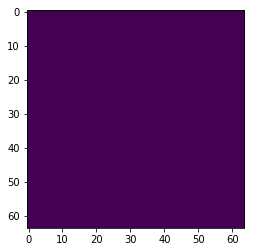

In [25]:
plt.imshow(pred)

In [26]:
real_data = tifffile.imread("/Users/xuyameng/Desktop/ah_0528_ym/LC08_L1TP_121038_20170728_20170728_01_RT_merge_align.tif")[:,:,[3,4,6]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


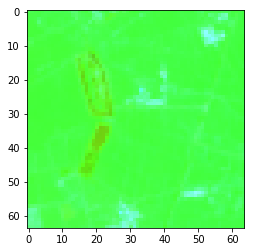

In [27]:
plt.imshow(real_data[2100:2164,2100:2164,:])

In [10]:
model.load_weights('wt.h5')